In [1]:
import numpy as np

class Graph:
    #TODO implement 8-point connectivity
    def __init__(self, pixel, goal, value, g=0, parent=None):
        self.pixel = pixel
        self.goal = goal
        self.parent = parent
        self.neighbors = {'u' : None, #up
                          'l' : None, #left
                          'd' : None, #down
                          'r' : None  #right
                          }
        self.h = self.heuristic()
        self.g = g
        self.obstacle = value
        self.f = self.h + self.g + 1e4 * self.obstacle
    
    def heuristic(self):
        pixel_arr = np.array(self.pixel)
        goal_arr = np.array(self.goal)
        return np.linalg.norm(goal_arr - pixel_arr)

    def add_neighbor(self, loc, npixel, nvalue):
        self.neighbors[loc] = Graph(npixel, self.goal, nvalue, g=self.g+1, parent=self)


In [203]:
a = Graph((1, 1), (2, 2), 0)
a.add_neighbor('u', (1, 2), 0)

In [204]:
a.neighbors['u'].g

1

In [48]:
#TODO check if x, y needs to be reversed
class A_star:
    def __init__(self, grid, start, goal):
        self.grid = grid
        self.shape = grid.shape
        self.start = start
        self.goal = goal
        self.graph = Graph(start, goal, grid[start[0], start[1]])
        self.O = [] # priority queue
        self.C = set() # visited nodes
        self.T = []
        self.path = None

    def _gen_path(self, node):
        curr = node
        order = []
        while curr:
            order.append(curr.pixel)
            curr = curr.parent
        self.path = order[::-1]
    
    def run(self):
        self.O.append(self.graph)
        tt = 0
        test = set()
        #ncurr = self.graph
        #self.C.append(self.graph)

        #while ncurr.pixel != self.goal:
        while self.O:
            ncurr = self.O.pop()
            self.T.append(ncurr)
            if ncurr.pixel in test:
                print(tt)
                print(test)
            test.add(ncurr.pixel)

            if ncurr.pixel == self.goal:
                #self.C.append(ncurr)
                self.O = list(filter(lambda x: x.f < ncurr.g, self.O))
            
            elif ncurr not in self.C:
                #self.C.append(ncurr)
                self.C.add(ncurr.pixel)
                if not ncurr.pixel[0] % 1:
                    pass
                    #print(ncurr.pixel, end='::')
                    #print(len(self.C), len(self.O), end=' >< ')
                for i, loc in enumerate(ncurr.neighbors.keys()):
                    move = (-1)**(0 < i < 3) * np.array([0**((i + 1) % 2), 0**(i % 2)]) # x,y
                    #move = (-1)**(0 < i < 3) * np.array([-0**(i % 2), 0**((i + 1) % 2)])  # y, x
                    next_pixel = tuple(np.array(ncurr.pixel) + move)
                    #C_pxs = [node.pixel for node in self.C]
                    O_pxs = [node.pixel for node in self.O]

                    if (next_pixel not in self.C) and (next_pixel not in O_pxs):
                        if (next_pixel[0] >= 0 and next_pixel[1] >= 0) and (next_pixel[0] < self.shape[0] 
                            and next_pixel[1] < self.shape[1]):
                                nvalue = self.grid[next_pixel[0], next_pixel[1]]
                                ncurr.add_neighbor(loc, next_pixel, nvalue)
                                self.O.append(ncurr.neighbors[loc])
                
                self.O.sort(key=lambda x : x.f, reverse=True)
                if tt == 0:
                    print([(node.pixel, node.f) for node in self.O])
            #ncurr = self.O.pop()
            tt += 1
        self._gen_path(ncurr)



In [287]:
grid = np.zeros((6,6))
goal = (5, 0)
start = (1, 5)
grid[0:4, 1:3] = 1
grid[4, 3] = 1
test = A_star(grid, (5,1), (0,5))

grid[0, 5] = 2
grid[5, 1] = 3
grid

array([[0., 1., 1., 0., 0., 2.],
       [0., 1., 1., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 3., 0., 0., 0., 0.]])

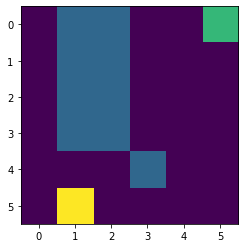

In [227]:
import matplotlib.pyplot as plt

plt.imshow(grid)
plt.show()

In [228]:
import cv2
cv2.transpose(grid)

array([[0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 3.],
       [1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0.],
       [2., 0., 0., 0., 0., 0.]])

In [288]:
test.run()

[((5, 0), 8.071067811865476), ((5, 2), 6.830951894845301), ((4, 1), 6.656854249492381)]


In [283]:
test.graph.neighbors['r'].neighbors['r'].neighbors['r'].g

3

In [279]:
ttt = test.T
a = list(filter(lambda x: x.f < 10, ttt))
print([n.pixel for n in a])
print()
print([n.pixel for n in ttt])

[(5, 1), (4, 1), (5, 2), (4, 2), (5, 3), (5, 0), (5, 4), (4, 4), (3, 4), (2, 4), (4, 0), (1, 4), (3, 0), (1, 5), (0, 4), (2, 5), (3, 5), (4, 5), (5, 5), (2, 0), (3, 3), (2, 3)]

[(5, 1), (4, 1), (5, 2), (4, 2), (5, 3), (5, 0), (5, 4), (4, 4), (3, 4), (2, 4), (4, 0), (1, 4), (3, 0), (1, 5), (0, 4), (2, 5), (3, 5), (4, 5), (5, 5), (2, 0), (3, 3), (2, 3), (1, 0), (1, 3), (0, 0), (0, 3), (3, 1), (3, 2), (4, 3), (2, 1), (1, 1), (0, 1), (2, 2), (1, 2), (0, 2), (0, 5)]


In [237]:
a = set()

(5,2) in a

False

In [183]:
print(test.graph.pixel)
for key, item in test.graph.neighbors.items():
    print(key, item)

(5, 1)
u <__main__.Graph object at 0x7f0164224c70>
l <__main__.Graph object at 0x7f0163ee9330>
d None
r <__main__.Graph object at 0x7f0163eeb040>


In [184]:
print(test.graph.neighbors['l'].f)
print(test.graph.neighbors['r'].f)

8.071067811865476
6.830951894845301


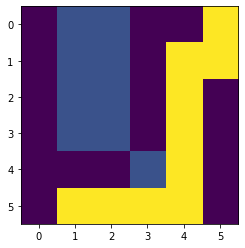

In [289]:
p = test.lastp
order = []
while p:
    order.append(p.pixel)
    grid[p.pixel] = 4
    p = p.parent
order[::-1]

plt.imshow(grid)
plt.show()

In [80]:
for i in range(1,6):
    print(f'5%{i} = ', 7%(i+1))

5%1 =  1
5%2 =  1
5%3 =  3
5%4 =  2
5%5 =  1


In [46]:
import os
import cv2

height, width = (16, 16) # in meters
scale = 28 # meters / pixel
def meters2pixels(coord):
    """Converts coordinate in meters to pixel coordinate.
    """
    xm, ym = coord
    xp = int(np.round(scale * (xm + width // 2)))
    yp = int(np.round(scale * (-ym + height // 2)))
    coord_pixels = (xp, yp)
    
    return coord_pixels

grid_path = os.path.join('catkin_ws/src/wavefront', 'worlds/grid1.npy')
grid = np.load(grid_path)
#grid = cv2.transpose(grid)

start = (-6, 2)
start_ = meters2pixels(start)
goal = (5, 2)
goal_ = meters2pixels(goal)
mapa = grid.copy()

mapa[goal_[1], goal_[0]] = 2
mapa[start_[1], start_[0]] = 3
grid


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint64)

In [33]:
grid = cv2.transpose(grid)
np.save('catkin_ws/src/Astar/worlds/grid1.npy', grid)
grid

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)

In [29]:
grid = cv2.transpose(grid)

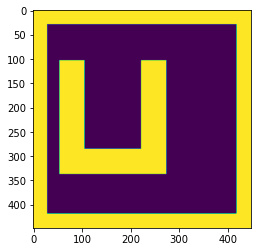

In [47]:
import matplotlib.pyplot as plt

plt.imshow(grid)
plt.show()

In [49]:
#test = A_star(grid, (start_[1],start_[0]), (goal_[1],goal_[0]))
test = A_star(grid, start_, goal_)
test.run()

[((55, 168), 310.0), ((56, 169), 309.00162337234525), ((56, 167), 309.00162337234525), ((57, 168), 308.0)]


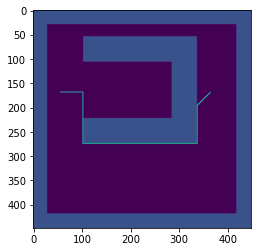

In [297]:
p = test.lastp
order = []
while p:
    order.append(p.pixel)
    mapa[p.pixel] = 4
    p = p.parent
#order[::-1]

plt.imshow(mapa)
plt.show()

In [52]:
import plotly.express as px
import plotly.graph_objects as go

a = np.array(list(map(list, zip(*test.path))))
fig = px.imshow(0**grid, binary_string=True)
fig.add_trace(go.Scatter(x=a[0,:].ravel(), y=a[1,:].ravel(), name='Caminho do Robô', showlegend=True))
fig.show()

In [43]:
import pandas as pd
df = pd.read_csv('/home/fbartelt/Documents/UFMG/Planejamento/logs/astar_path.csv', index_col=0)
df

,0,1
0,168,56
1,168,57
2,168,58
3,168,59
4,168,60
...,...,...
516,170,362
517,170,363
518,169,363
519,169,364


In [45]:
fig = px.imshow(0**grid, binary_string=True)
fig.add_trace(go.Scatter(x=df['1'], y=df['0'], name='Caminho do Robô', showlegend=True))
fig.show()

In [55]:
def pixels2meters(coord):
    """Converts pixels coordinate to coordinate in meters.
    """
    xp, yp = coord
    xm = xp / scale - width // 2
    ym = -yp / scale + height // 2
    coord_meters = (xm, ym)
    
    return coord_meters

pixels2meters((168, 56))

(-2.0, 6.0)

In [62]:
import time

a = time.time()
time.sleep(1.234)
b = time.time()
tt = b - a
m, s = divmod(tt, 60)
ss = '{:.2}min {:.2}s'.format(m, s)
print(ss)

0.0min 1.2s


In [63]:
mapa[None]

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]], dtype=uint64)

# Trapezoidal

In [11]:
height, width = (16, 16) # in meters
scale = 28 # meters / pixel

def meters2pixels(coord):
    """Converts coordinate in meters to pixel coordinate.
    """
    xm, ym = coord
    xp = int(np.round(scale * (xm + width // 2)))
    yp = int(np.round(scale * (-ym + height // 2)))
    coord_pixels = (xp, yp)
    
    return coord_pixels

def pixels2meters(coord):
    """Converts pixels coordinate to coordinate in meters.
    """
    xp, yp = coord
    xm = xp / scale - width // 2
    ym = -yp / scale + height // 2
    coord_meters = (xm, ym)
    
    return coord_meters

In [28]:
import plotly.express as px
import cv2
img = cv2.imread('trapz.png', cv2.IMREAD_GRAYSCALE)
img = img / 255
fig = px.imshow(img)
fig.show()

In [29]:
corners = [
           [4, 121], [31, 110], [39, 4], [48, 56], [58, 248], [81, 28], 
           [100, 183], [143, 101], [147, 215], [174, 104], [184, 250],
           [198, 7], [218, 97], [252, 80]
           ]
corners = [tuple(x) for x in corners]
for corner in corners:
    img[corner[1], corner[0]] = 2

fig = px.imshow(img)
fig.show()

In [24]:
img[1, 1]

1.0

# GVD

In [45]:
import numpy as np
import plotly.express as px
import pandas as pd
step = (2*np.pi)/1440
step

0.004363323129985824

In [57]:
df = pd.read_csv('/home/fbartelt/Documents/UFMG/Planejamento/logs/GVD.csv', index_col=0)
fig = px.scatter(df, x='0', y='1')
fig.show()